In [2]:
# !sudo pip install pymssql
# !sudo pip install pydot
# !sudo pip install pydotplus
# !sudo pip install graphviz
# !sudo apt-get install graphviz


# 1 -Luot xem
# 2 - Luot mua
# 3 - Bo khoi gio hang
# 4 - San pham xem lien truoc

In [291]:
import os
import networkx as nx
import pandas as pd
import time
import sys
reload(sys)
sys.setdefaultencoding('utf-8')
import numpy as np
import re
import json
import datetime
import dateutil.parser

In [296]:
'''
Created on 27 Mar 2016

@author: lbtanh
'''
import pymssql
from os import getenv
server = "10.1.12.197"
user = "rd"
password = "rd123456"
conn = pymssql.connect(server, user, password, "RD")
cursor = conn.cursor(as_dict = True)


In [281]:
# select tracking data
start = time.time()
# tracking_data = 'use RD SELECT [COOKIE] ,[SESSION],[CREATEDTIME],[URL]  FROM [RD].[dbo].[TRACKINGDATA] where SITEID = 8'
tracking_data = 'use RD SELECT [COOKIE] ,[SESSION],[CREATEDTIME], [RD].[dbo].[TRACKINGDATA].[URL], vuivui.Product.ProductID, vuivui.Product.CategoryID FROM [RD].[dbo].[TRACKINGDATA] left join [RD].[vuivui].[Product] on vuivui.Product.Url = RD.dbo.TRACKINGDATA.URL where SITEID = 8'
cursor.execute(tracking_data)
tracking_data = cursor.fetchall()
tracking_data = pd.DataFrame(tracking_data)
time.time() - start 

105.19970393180847

In [297]:

hot_product = 'use RD SELECT RD.dbo.TRACKINGDATASUMMARIZE.ProductID, Price, SUM(Value) as Views, vuivui.Product.CategoryID FROM RD.dbo.TRACKINGDATASUMMARIZE join vuivui.Product on vuivui.Product.ProductID = RD.dbo.TRACKINGDATASUMMARIZE.ProductID where Type = 1  group by RD.dbo.TRACKINGDATASUMMARIZE.ProductID, RefProductID, Price, ProductName, vuivui.Product.CategoryID order by vuivui.Product.CategoryID,SUM(Value) desc'
cursor.execute(hot_product)
hot_product = cursor.fetchall()
hot_product = pd.DataFrame(hot_product)

In [298]:
# get all product id in site vuivui.com
list_product = 'use RD select ProductID from vuivui.Product'
cursor.execute(list_product)
list_product = cursor.fetchall()
list_product = pd.DataFrame(list_product)

In [299]:
conn.close()

In [293]:
# select tracking table
sql = "SELECT RD.dbo.TRACKINGDATASUMMARIZE.ProductID, RefProductID, Price, ProductName, SUM(Value) as Views, vuivui.Product.CategoryID FROM RD.dbo.TRACKINGDATASUMMARIZE join vuivui.Product on vuivui.Product.ProductID = RD.dbo.TRACKINGDATASUMMARIZE.RefProductID where Type = 4 group by RD.dbo.TRACKINGDATASUMMARIZE.ProductID, RefProductID, Price, ProductName, vuivui.Product.CategoryID order by SUM(Value) desc"
sql1 = 'SELECT * FROM RD.dbo.TRACKINGDATASUMMARIZE where ProductID != RefProductID AND DayKey = 20170326 order by Value desc'
cursor.execute(sql)
a = cursor.fetchall()

#get info product
produc_cate = 'use RD SELECT [ProductID] ,[ProductName] ,[CategoryID] ,[Price] FROM [RD].[vuivui].[Product]'
cursor.execute(produc_cate)
info_product = cursor.fetchall()
info_product_all = pd.DataFrame(info_product)
info_product  = info_product_all.drop_duplicates()

In [294]:
conn.close()

In [295]:
info_product_all.shape

(13754, 4)

In [341]:
# select product name in tracking
# sql3 = 'use RD'\
# ' SELECT RefProductID, Price, ProductName'\
#   ' FROM RD.dbo.TRACKINGDATASUMMARIZE'\
#   ' join vuivui.Product on vuivui.Product.ProductID = RD.dbo.TRACKINGDATASUMMARIZE.RefProductID'\
#   ' group by RD.dbo.TRACKINGDATASUMMARIZE.ProductID, RefProductID, Price, ProductName'
# cursor.execute(sql3)
# c = cursor.fetchall()
# name  = pd.DataFrame(c)
# conn.close()

In [300]:
data_graph = pd.DataFrame(a)
data_graph = data_graph[data_graph['Price'] != -1]
data_graph = data_graph[data_graph['Price'] != 0]

test = data_graph[['ProductID','RefProductID', 'Views']]
testA = data_graph#all dataset


In [302]:
# testA = testA.rename(columns={'ProductName':'RefProductName'})
# name  = name.drop_duplicates()
# join 
testA = pd.merge(testA, info_product.iloc[:,],how = 'left', left_on = 'ProductID',right_on = 'ProductID')
testA.rename(columns={'Price_x':'RefPrice', 'Price_y':'ProductPrice', 'CategoryID_x':'RefCategoryID', 'CategoryID_y':'CategoryID', 'ProductName_x':'RefProductName', 'ProductName_y':'ProductName'}, inplace=True)

# drop NaN value in columns RefProductID
testA = testA.dropna(axis = 0, how='any', subset = ['RefProductID', 'ProductID'])
testA = testA.loc[:,['ProductID', 'ProductName', 'ProductPrice', 'RefProductID', 'RefProductName','RefPrice', 'Views', 'CategoryID', 'RefCategoryID']]

# Remove accent Vietnamese

In [303]:
def rmlistchar(text):
    a = re.findall(r"[^][)\"(']", text)
    a = ''.join(a)
    return a

# !pip install Graphviz
# download version *.msi
#remove accents vietnamese
def remove_accents(text):
    s1 = u'ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝàáâãèéêìíòóôõùúýĂăĐđĨĩŨũƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ'
    s0 = u'AAAAEEEIIOOOOUUYaaaaeeeiioooouuyAaDdIiUuOoUuAaAaAaAaAaAaAaAaAaAaAaAaEeEeEeEeEeEeEeEeIiIiOoOoOoOoOoOoOoOoOoOoOoOoUuUuUuUuUuUuUuYyYyYyYy'
#     s1.encode('utf-8')
#     s0.encode('utf-8')
    if text == np.nan or text == np.NAN or text == np.NaN:
        return text
    else:    
        s = ''
        text = str(text)
        text = text.decode('utf-8')

        for c in text:
            if c in s1:
                s += s0[s1.index(c)]
            else:
                s += c
        return s.strip()

    
# remove accent and stopwords
# ProductID	ProductName	ProductPrice	RefProductID	RefProductName	RefPrice	Views

testA[['ProductName', 'RefProductName']] = testA[['ProductName', 'RefProductName']].applymap(remove_accents)
testA[['ProductName', 'RefProductName']] = testA[['ProductName', 'RefProductName']].applymap(rmlistchar)

# testA.iloc[:, 0] = testA.iloc[:,0].apply(lambda x: int(float(x)))#convert to int
# testA.RefProductID = testA.RefProductID.apply(lambda x: int(float(x)))#convert to int
# testA.iloc[:, 6] = testA.iloc[:,6].apply(lambda x: int(float(x)))#convert to int
# testA.iloc[:, 7] = testA.iloc[:,7].apply(lambda x: int(float(x)))#convert to int
# testA.iloc[:, 1] = testA.iloc[:, 1].apply(rmlistchar)
# testA.iloc[:, 4] = testA.iloc[:, 4].apply(rmlistchar)    


In [ ]:
# visual graph
# test.cloumns = ['ProductID	ProductName	ProductPrice	RefProductID	RefProductName	RefPrice	Views']
def drawn_graph(test):
#     test = test.applymap(lambda x: int(x))

    #write to file
    f = open('demo.txt','w')
    f.writelines('digraph G {\nnode [width=.5,height=.3,style=filled,color=skyblue, fixedsize=false];\noverlap="true";\nsize="1000";\nconcentrate=false;\nrankdir="LR";\n')
    f.writelines

    for i in range(test.shape[0]):     
        #get weight
        weight = test.iloc[i][6]
        if(weight < 1000):
            clor = 'black'
        elif weight < 2000:
            clor = 'green'
        elif weight < 4000:
            clor = 'blue'
        else:
            clor = 'red'
        #RefPrice	ProductID	RefProductName	RefProductID	Views	ProductPrice	ProductName    
        s= '      "'+ str(test.iloc[i][1])+'\n' + str(test.iloc[i][2])+'"'
        s +=  ' -> ' + '"'+ str(test.iloc[i][4])+'\n'+str(test.iloc[i][5])+'"' + ' [label="' + str(weight) + '",penwidth='+str(round(test.iloc[i][6]/2000, 2))+',color='+clor+']'
        if s!='      '+ str(test.iloc[i][6]):
            s+=';\n'
            f.writelines(s)

    f.writelines('}')
    f.close()

    #generate graph image from graph text file
#     os.system("dot -Tpng -odemo.png demo.txt")


In [ ]:
# drawn_graph(testA[:20])
# # command line (cmd)
# !dot -Tpng -x -odemo.png demo.txt

In [ ]:
# try:
#     import matplotlib.pyplot as plt
# except:
#     raise 
    
# import networkx as nx

# G=nx.path_graph(8)
# nx.draw(G)
# plt.savefig("simple_path.png") # save as png
# plt.show() # display
# nx.nx_pydot.write_dot(G, 'writedot.txt')
# G1 = nx.nx_pydot.read_dot('DiGraph.txt')

In [ ]:
# G1 = nx.nx_pydot.read_dot('WeightGraph.txt')
# type(G1)
# G1.subgraph()

In [ ]:
# # save image
# import pygraphviz as pgv
# from IPython.display import Image

# G=pgv.AGraph('dotgraph.txt')
# G.layout(prog = 'dot')
# G.draw('testgraph1.png')
# Image(filename='testgraph1.png') 

In [ ]:
# save dataframe to txt (edgelist format to read into networkx)
# import numpy as np
# np.savetxt(r'/home/tgdd/TA_69/recommenderr/tracklog.txt', df_tmp.values, fmt='%s', delimiter='\t')

# undirected graph
# tracklog = nx.read_edgelist('tracklog.txt', nodetype=int, data=(('weight',int),))

# nx.nx_pydot.write_dot(g, 'g.txt')
# os.system("dot -Tpng -og.png g.txt")

# Create graph

In [304]:
# input: dataframe testA
# create graph by ID
def create_graph(test):
    g = nx.DiGraph((raw['ProductID'], raw['RefProductID'], {'weight': raw['Views']}) for index, raw in test.iterrows())
    return g

# create graph by name
def create_graph1(test):
    g = nx.DiGraph((raw['ProductName'], raw['RefProductName'], {'weight': raw['Views'], 'label':str(raw['Views'])}) for index, raw in test.iterrows())
    return g

In [ ]:
# start = time.time()
# g1 = create_graph1(testA[0: -1])
# g = create_graph(testA[0: -1])
# duration = time.time() - start
# g1.edges()

In [ ]:
duration

# Get testdata

In [ ]:
# get subgraph to test RD by mr.Tan
# create new graph
G1 = nx.DiGraph()#new graph
for edge in g.in_edges([87839, 88540, 88397, 88537, 90342, 91748, 92015, 86689, 91751, 92073], data = True):
    if len(edge) > 0 and float(edge[2]['weight']) > 100: #some nodes have zero edges going into it
        G1.add_edge(edge[0], edge[1],weight= edge[2]['weight'])
for edge in g.out_edges([87839, 88540, 88397, 88537, 90342, 91748, 92015, 86689, 91751, 92073], data = True):
    if len(edge) > 0 and float(edge[2]['weight']) > 100: #some nodes have zero edges going into it
        G1.add_edge(edge[0], edge[1],weight= edge[2]['weight'])   


In [ ]:
list_it=pd.DataFrame(G1.edges())[0].tolist()
list_it = list(set(list_it))

In [ ]:
# pd.DataFrame(G1.edges(data = True))

In [ ]:
# [86689,  92962, 91781, 72198, 91751, 86152, 89161, 73898, 88268, 74017]
H = g.subgraph(list_it)
nx.nx_pydot.write_dot(H, 'RD_AT.txt')

In [ ]:
RD_AT= pd.DataFrame(H.edges(data= 'weight'))
RD_AT.columns = ['ProductID', 'RefProductID', 'Views']

In [ ]:
RD_AT=RD_AT.merge(name, how = 'left', left_on='ProductID', right_on='RefProductID')
del RD_AT['RefProductID_y']
RD_AT= RD_AT.merge(name, how = 'left', left_on='RefProductID_x', right_on='RefProductID')
del RD_AT['RefProductID_x']
RD_AT=RD_AT.rename(columns={'Price_x':'Price', 'ProductName_x': 'ProductName', 'Price_y': 'RefPrice', 'ProductName_y':'RefProductName'})


In [ ]:
# create graph by dataframe
H1 = nx.DiGraph((raw['ProductName'], raw['RefProductName'], {'weight': raw['Views'], 'label':str(raw['Views']), 'penwidth':1}) for index, raw in RD_AT.iterrows())
# 'penwidth':str(round(raw['Views']/2000, 2))
nx.nx_pydot.write_dot(H1, 'RD_AT1.txt')

In [ ]:
list_test = [87839, 88540, 88397, 88537, 90342, 91748, 92015, 86689, 91751, 92073]
# Get list item with property of them
property_list = name[name['RefProductID'].isin(list_test)]#list_it or list_test
ew = pd.ExcelWriter('/home/tgdd/TA_69/recommenderr/list_test.xlsx', options={'encoding':'utf-8'})
property_list.to_excel(ew, 'list_test')
ew.save()

property_list=name[name['ProductID'].isin(list_it)]#list_it or list_test
ew = pd.ExcelWriter('/home/tgdd/TA_69/recommenderr/list_property.xlsx', options={'encoding':'utf-8'})
property_list.to_excel(ew, 'list_property')
ew.save()


# competing product (same or not same with branch)

In [ ]:
 # read into graph   
testA.loc[:,['ProductID', 'RefProductID', 'Views']] = testA.loc[:,['ProductID', 'RefProductID', 'Views']].applymap(lambda x: int(float(x)))
test1= testA.iloc[:200, ]


In [ ]:
#read dataset ten_hang and normalize
tenhang = pd.read_excel('/home/tgdd/TA_69/recommenderr/Property_vuivui.xlsx', sheetname='Sheet3', header = 0)
#df = df.replace(np.NAN, 'Not available')

In [ ]:
tenhang1 = tenhang.iloc[:, [0, 4]]
tenhang1.columns = ['Ma san pham', 'Hang san xuat']
test1 = test1.join(tenhang1.set_index('Ma san pham'), on = 'ProductID')
test1 = test1.rename(columns = {'Hang san xuat':"ProBranch"})
test1 = test1.join(tenhang1.set_index('Ma san pham'), on = 'RefProductID')
test1 = test1.rename(columns = {'Hang san xuat':"RefBranch"})

In [ ]:
#to change competing_product have the same branch
# test1 = test1[test1['ProBranch']==test1['RefBranch']]

In [ ]:
test1 = test1.dropna(axis = 0, how='any', subset = ['ProBranch', 'RefBranch'])

In [ ]:
g = nx.DiGraph((raw['ProductID'], raw['RefProductID'], {'weight': raw['Views'], 'label':str(raw['Views'])}) for index, raw in test1.iterrows())
# print(g.edges(data=True))

In [ ]:
# calculate: competing product 
tmp = []#list of tuple to write into Graph
for node in g.nodes():
    for out_node in g.successors(node):
        if g.has_successor(out_node, node):
            a = abs(g[node][out_node]['weight'] - g[out_node][node]['weight'])/(1.0 * max(g[node][out_node]['weight'],g[out_node][node]['weight']))
            if a  < 0.25:# ratio between the number of Views of 2 product
                tmp.append((node, out_node,g[node][out_node]['weight'], a))

In [ ]:
# convert list of tuple to df
tmp = sorted(tmp, key = lambda x: x[3], reverse= False)
df_tmp = pd.DataFrame(tmp)
df_tmp.columns = ['ProductID', 'RefProductID', 'Views', 'Weight']

In [ ]:
#vlookup
df_tmp = df_tmp.merge(name.iloc[:, 1:3], how = 'left', left_on='ProductID', right_on='RefProductID')
del df_tmp['RefProductID_y']
df_tmp = df_tmp.rename(columns={'RefProductID_x':'RefProductID'})
df_tmp = df_tmp.merge(name.iloc[:, 1:3], how = 'left', left_on='RefProductID', right_on='RefProductID')

In [ ]:
# df_tmp.iloc[:, [0, 1, 2]]= df_tmp.iloc[:, [0, 1, 2]].applymap(lambda x: int(x))
df_tmp = df_tmp.iloc[:-1, ]#how many pair product do you want to get
df_tmp = df_tmp.sort_values(['Weight', 'Views'])

In [ ]:
# g1 = nx.DiGraph((raw['ProductName_x'], raw['ProductName_y'], {'weight': raw['Views'], 'label':(str(raw['Weight'])+'\n'+str(raw['Views']))}) for index, raw in df_tmp.iterrows())
# g1 = g1.to_undirected(reciprocal = True)

# the same with two lines above
df_tmp = df_tmp.iloc[::2]
g1 = nx.Graph((raw['ProductName_x'], raw['ProductName_y'], {'weight': raw['Views'], 'label':(str(raw['Weight'])+'\n'+str(raw['Views']))}) for index, raw in df_tmp.iterrows())

nx.nx_pydot.write_dot(g1, 'RD_AT.txt')

In [ ]:
#

In [83]:
#write to excel
ew = pd.ExcelWriter('/home/tgdd/TA_69/recommenderr/cunghang.xlsx', options={'encoding':'utf-8'})
df_tmp.to_excel(ew, 'cunghang')
ew.save()

# #read file excel
# dataframe = pd.read_excel('/home/tungrd/TA/recommenderr/thesameall.xlsx', sheetname='thesameall', header = 0, index_col=0 )

In [106]:
# can not install graphviz on ubuntu 16.04 server, 
# !dot -Tpng -x -ocunghang.png cunghang.txt
# sorted(g1.edges('Samsung Galaxy A7 (2017)', data= 'weight'), key = lambda x: x[2], reverse= True)

In [185]:
#Cây khung, tra ve do thi, moi canh co trong so lon nhat
G1 = nx.Graph()#new graph
#for each node in nodes, add edges(u, v) into G1, which have the degree = max
for node in g1.nodes():
    edges = g1.edges(node, data=True)
    if len(edges) > 0: #some nodes have zero edges going into it
        max_weight = max([edge[2]['weight'] for edge in edges])
        for edge in edges:
            if edge[2]['weight'] == max_weight:
                G1.add_edge(edge[0], edge[1],weight= edge[2]['weight'])
                
G1.edges(data = True)                

In [187]:
G1.number_of_nodes()
G1.number_of_selfloops()
nx.nx_pydot.write_dot(G1, 'cunghang.txt')

1752

In [159]:
# import networkx as nx

# G = nx.Graph()
# G.add_edge('A','B', weight=1.0)
# G.add_edge('A','C', weight=1.0)
# G.add_edge('A','D', weight=0.5)
# G.add_edge('B','C', weight=0.9)
# G.add_edge('B','D', weight=0.8)
# G.add_edge('C','D', weight=0.9)

# print "all edges"
# print G.edges(data=True)

# print "edges >= 0.9"
# print [(u,v,d) for (u,v,d) in G.edges(data=True) if d['weight'] >= 0.9]

# print "sorted by weight"
# print sorted(G.edges(data=True), key=lambda (source,target,data): data['weight'])


# G1 = nx.Graph()
# for node in G.nodes():
#     edges = G.edges(node, data=True)
#     if len(edges) > 0: #some nodes have zero edges going into it
#         max_weight = max([edge[2]['weight'] for edge in edges])
#         for edge in edges:
#             if edge[2]['weight'] == max_weight:
#                 G1.add_edge(edge[0], edge[1],weight= edge[2]['weight'])
                

In [164]:
nx.nx_pydot.write_dot(a, 'a.txt')
# # run command line
# os.system("dot -Tpng -oa.png a.txt")
# a =nx.maximum_branching(g)

In [ ]:
# end

In [22]:
# find root node of tree by recursion
def find_root(G,node):
    if G.predecessors(node):  #True if there is a predecessor, False otherwise
        root = find_root(G,G.predecessors(node)[0])
    else:
        root = node
    return root

In [ ]:
#get limit time execute program
import sys
sys.getrecursionlimit()
sys.setrecursionlimit(10000)
find_root(g,74017)

In [11]:
# find root node
[n for n,d in g.in_degree().items() if d==0] 

[92082, 80639]

In [ ]:
# we need to solve: find root node, or in_degree is smallest and out_degree is largest

# Test hang

In [217]:
#read dataset and normalize
data_ = pd.read_excel('/home/tgdd/TA_69/recommenderr/Property_vuivui.xlsx', sheetname='by_branch', header = 0)
#df = df.replace(np.NAN, 'Not available')

In [383]:
data_hang = data_[data_['Total']>1000]


In [238]:
# data_hang['Total'].groupby([data_hang['Branch'], data_hang['RefBranch']]).sum()
g_hang = nx.DiGraph((raw['Branch'], raw['RefBranch'], {'weight': raw['Total'], 'label':str(raw['Total'])}) for index, raw in data_hang.iterrows())
# print(g.edges(data=True))
nx.nx_pydot.write_dot(g_hang, 'g_hang.txt')
os.system("dot -Tpng -og_hang.png g_hang.txt")


32512

In [239]:
# Remove selfloop egdes
for node in g_hang.nodes():
    if(g_hang.has_edge(node, node)):
        g_hang.remove_edge(node, node)

In [240]:
G1 = nx.DiGraph()#new graph
#for each node in nodes, add edges(u, v) into G1, which have the degree = max
for node in g_hang.nodes():
    edges = g_hang.out_edges(node, data=True)
    if len(edges) > 0: #some nodes have zero edges going into it
        max_weight = max([edge[2]['weight'] for edge in edges])
        for edge in edges:
            if edge[2]['weight'] == max_weight:
                G1.add_edge(edge[0], edge[1],weight= edge[2]['weight'])

# Plot data

In [581]:
# import numpy as np
# ts = pd.Series(np.random.randn(1000), index=pd.date_range('1/1/2000', periods=1000))
# ts = ts.cumsum()
# ts.plot()
# plt.show()

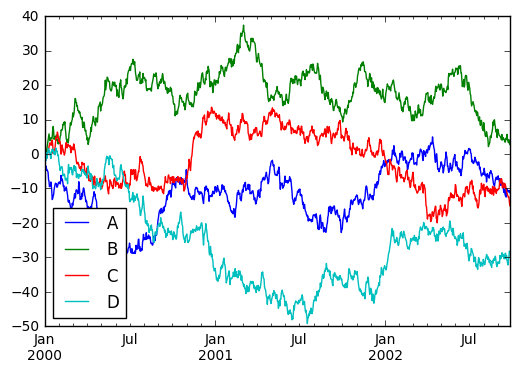

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.DataFrame(np.random.randn(1000, 4), index = ts.index, columns=list('ABCD'))

df = df.cumsum(axis = 0)
plt.figure(); df.plot(); plt.legend(loc='best')
plt.show()

In [582]:
# df.plot(subplots=True, figsize=(6, 6)); plt.legend(loc='best')
# plt.show()

In [251]:
tmp_plot = plot_data.iloc[:-1,:]
tmp_plot = tmp_plot[tmp_plot['DayKey']!=0]
tmp_plot = tmp_plot[tmp_plot['DayKey']!=20170322]
tmp_plot.DayKey = tmp_plot.DayKey.apply(lambda x: str(x))
tmp_plot.DayKey= tmp_plot.DayKey.str[0:4] +'-'+tmp_plot.DayKey.str[4:6] +'-'+tmp_plot.DayKey.str[6:8]
tmp_plot.DayKey = tmp_plot.DayKey.apply(lambda x: pd.Timestamp(x))


In [252]:
# ========================= write to file ===================================================
#Get Views Info by Date,
# [86689,  92962, 91781, 72198, 91751, 86152, 89161, 73898, 88268, 74017]
tmp_plot = tmp_plot[tmp_plot['ProductID'].isin(list_it)
         & (tmp_plot['Value']>0)
         & tmp_plot['RefProductID'].isin(list_it)]
#write to excel, number of views
ew = pd.ExcelWriter('/home/tgdd/TA_69/recommenderr/info10_view.xlsx', options={'encoding':'utf-8'})
tmp_plot.to_excel(ew, 'info10_view')
ew.save()

In [25]:
#Get info of list _ product
data = pd.read_excel('/home/tgdd/TA_69/recommenderr/Property_vuivui.xlsx', sheetname='Sheet3', header = 0)
data= data.rename(columns={' Category':'Category'})
df = data[data['Category'] == 42]
nunique = df.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
df = df.drop(cols_to_drop, axis=1)
df = df.dropna(axis = 1, how='all')
info10 = df
# info10 = df[df.icol(0).isin(list_it)]
# info10 = info10.dropna(axis = 1, how='all')

In [29]:
# get product property 
info10 = info10[[u'Mã sản phẩm', u'Tên sản phẩm',  u'Hãng sản xuất', u' Giá', u'RAM',u'Tốc độ CPU',u'Màn hình rộng', u'Chipset (hãng SX CPU)', u'Bộ nhớ trong']]
info10[u'Chipset (hãng SX CPU)']= info10[u'Chipset (hãng SX CPU)'].apply(remove_accents)
def sonhan(text):
    var1 = re.findall(r"\d\ nhan", str(text))
    if len(var1)>0:
        var1 = var1[0]
    else:
        var1 = np.nan
    return var1

def manhinh(text):
    var1 = re.findall(r"\d+\.?\d*", str(text))
    if len(var1)>0:
        var1 = var1[0]
    else:
        var1 = ''
    return var1

def cpu(text):
    var1 = re.findall(r"\d+\.?\d* GHz", str(text))
    if len(var1)>0:
        var1 = var1[0]
    else:
        var1 = ''
    return var1
    

info10['So nhan'] = info10[u'Chipset (hãng SX CPU)'].apply(sonhan)
info10['Man hinh rong'] = info10[u'Màn hình rộng'].apply(manhinh)
#write to excel

ew = pd.ExcelWriter('/home/tgdd/TA_69/recommenderr/info10.xlsx', options={'encoding':'utf-8'})
info10.to_excel(ew, 'info10')
ew.save()

# ===================================== the ends (write to file) ==============================

In [42]:
# aggregations = {
#     'duration': { # work on the "duration" column
#         'total_duration': 'sum',  # get the sum, and call this result 'total_duration'
#         'average_duration': 'mean', # get mean, call result 'average_duration'
#         'num_calls': 'count'
#     },
#     'date': {     # Now work on the "date" column
#         'max_date': 'max',   # Find the max, call the result "max_date"
#         'min_date': 'min',
#         'num_days': lambda x: max(x) - min(x)  # Calculate the date range per group
#     },
#     'network': ["count", "max"]  # Calculate two results for the 'network' column with a list
# }
 
# # Perform groupby aggregation by "month", but only on the rows that are of type "call"
# data[data['item'] == 'call'].groupby('month').agg(aggregations)

# # Group the data frame by month and item and extract a number of stats from each group
# data.groupby(['month', 'item']).agg({'duration':sum,      # find the sum of the durations for each group
#                                      'network_type': "count", # find the number of network type entries
#                                      'date': 'first'})    # get the first date per group

In [53]:
#groupby ProductID
groupbyID = tmp_plot.groupby(['ProductID']).agg({'Value':sum})
groupbyID=groupbyID.sort(columns='Value', ascending=False)
list_draw= groupbyID.head(10).index.tolist() #number of product to drawn

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [54]:
grouped = tmp_plot.groupby(['DayKey','ProductID','RefProductID']).agg({'Value':sum})
# grouped.get_group('20170418')  
# grouped = dict(list(grouped))
grouped = grouped.reset_index()
grouped =grouped.set_index(grouped['DayKey'])

In [55]:
#
list_name = pd.DataFrame(list_draw, columns= ['RefProductID'])
list_name = list_name.merge(name[['RefProductID','ProductName']], how='left', on= 'RefProductID')

In [56]:
df = grouped.pivot_table(values= 'Value', index = 'DayKey', columns='ProductID', fill_value=0)


In [57]:
# tmp_plot[tmp_plot['DayKey']=='20170419'][tmp_plot['ProductID']==98826]
# tmp = grouped[grouped['ProductID']==92569][[ 'Value']]
df = df[list_draw[0:10]]
df.columns = list_name.ProductName[0:10]


In [58]:
plt.figure(figsize = (30, 30)); df.plot()

# plt.legend(loc='best')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), fancybox=True, shadow=True, ncol=5)
plt.show()

NameError: name 'plt' is not defined

In [ ]:
## tmp.plot()
# plt.axis('normal')
plt.xticks(tmp.index, rotation='vertical')

plt.show()

### initial graph

In [34]:
tmpID = info_product
categoryID = tmpID.CategoryID.unique().tolist()
# testA[(testA.CategoryID == 42) & (testA.RefCategoryID == 42)].shape

In [86]:
#create multiple varibles, format cate_42
#each category have 
#strvar = 'cate_'+str(cate)+ '= testA[testA.CategoryID =='+str(cate)+']'
for cate in categoryID:
    exec('cate_'+str(cate)+ '= testA[(testA.CategoryID =='+str(cate)+ ') & (testA.RefCategoryID ==' +str(cate)+')]')
    exec('g_'+str(cate)+ '= create_graph(cate_'+str(cate)+')')

# recommended by hot products

In [ ]:
# # nx.set_node_attributes(g,1, 'test_' )
# G = nx.Graph()
# # ... build or do whatever to the graph
# nodes = filter(lambda (n, d): d['color'] == 'red', G.nodes_iter(data=True))
# subgraph = G.subgraph(nodes)

In [146]:
#return list of product have the Price difference less than #threshold_Price_Percent
# dataframe have format: ProductID | Weight | Price
# 
def Price_threshold(product_id, numofpro, df, info_product,threshold_Percent = 0.15, threshold_Views =10):
    cate_pro = int(info_product['CategoryID'][info_product['ProductID']==product_id])
    df = df[df['CategoryID']==cate_pro]
#     g = create_graph(df[:-1])
#     degree_weight = pd.DataFrame(g.degree(weight='weight').items())
#     degree_weight.columns = ['ProductID', 'Weight']
#     degree_weight=degree_weight.sort_values('Weight',axis=0, ascending=False)
#     degree_weight = degree_weight[degree_weight['Weight']>threshold_Views]
#     df_hot_list = degree_weight.merge(info_product[['ProductID', 'Price']], how ='left', left_on='ProductID', right_on='ProductID')

#     df_hot_list.Price = df_hot_list.Price.map(lambda x: float(x))

    product_Price = float(info_product[info_product['ProductID']==product_id]['Price'])
    list_Item = [raw for index, raw in df.iterrows() if abs(raw['Price'] - product_Price)/product_Price < threshold_Percent]
    result = pd.DataFrame(list_Item[:numofpro]).sort(columns = ['Views'], ascending = False)
#     return result[result.ProductID != product_id].ProductID.tolist()
    return result[result.ProductID != product_id]


In [149]:
list_hot_pro = Price_threshold(74645, 5, hot_product, info_product)
list_hot_pro = list_hot_pro.merge(info_product[['ProductID', u'ProductName']], how='left', left_on='ProductID', right_on='ProductID')
list_hot_pro

,CategoryID,Price,ProductID,Views,ProductName
0,1943.0,5380000.0,84916.0,27162.0,Tủ lạnh Panasonic NR-BA178PSVN
1,1943.0,6160000.0,84922.0,18560.0,Tủ lạnh Panasonic NR-BA228PSVN
2,1943.0,5690000.0,71398.0,18028.0,Tủ lạnh LG GN-L205PS 189 lít
3,1943.0,5990000.0,71397.0,13709.0,Tủ lạnh LG GN-L205BS 189 lít
4,1943.0,6160000.0,80735.0,8164.0,Tủ lạnh Aqua 204 lít AQR-I226BN


# recommended by tracking data

In [475]:
# return 
def out_graph(df, info_product, productid, numofpro, typegraph = 'out'):
    # return list of tuples which was sorted by weight out edges
    cate_pro = int(info_product['CategoryID'][info_product['ProductID']==productid])
#     df = df[df['CategoryID']==cate_pro]
#     g = create_graph(df[:-1])
    exec('g=g_'+str(cate_pro))
    if typegraph == 'out':
        df_weight = pd.DataFrame(g.out_edges(productid, data='weight'))
        df_weight.columns = ['ProductID','RefProductID', 'Views']
        df_weight=df_weight.sort(columns = ['Views'], ascending = False)[:numofpro]
#         tmp = testA[testA.columns][testA.RefProductID.isin(df_weight['RefProductID'])]
#         return tmp[tmp.ProductID == productid]
    else:
        df_weight = pd.DataFrame(g.in_edges(productid, data='weight'))
        df_weight.columns = ['ProductID','RefProductID', 'Views']
        df_weight=df_weight.sort(columns = ['Views'], ascending = False)[:numofpro]
#         tmp = testA[testA.columns][testA.ProductID.isin(df_weight['ProductID'])]
#         return tmp[tmp.RefProductID == productid]
    #sorted by 
    return df_weight

In [476]:
out_graph(testA, info_product, 84916, 5, 'out')

,ProductID,RefProductID,Views
54,84916,71398,1180.0
3,84916,89177,792.0
98,84916,84922,759.0
43,84916,69308,383.0
53,84916,71397,362.0


# Webservice

In [330]:
import zeep
import sys
reload(sys)
sys.setdefaultencoding('utf-8')

wsdl = 'http://clusterapi.thegioididong.com/ProductSvc.svc?wsdl'
client = zeep.Client(wsdl=wsdl)
# len(client.service.GetProductDetailByProductID(92082))
# client.service.GetProductDetailByProductID(92082)[2]['propertyNameField']

In [332]:
# client.service.GetProduct(8, 75373, 3, "vi-VN", "")

In [307]:
list_product = info_product_all.drop_duplicates(subset = ['CategoryID'], keep = 'first')

In [308]:
dth = info_product_all[info_product_all.CategoryID==42]

In [435]:
# client.service.GetProduct(8, 75373, 3, "vi-VN", "")
list_product = dth.ProductID.tolist()
list_name = []
for productID in list_product:
    a = len(client.service.GetProductDetailByProductID(productID))
    for Property in range(a):
        propertyNameField = client.service.GetProductDetailByProductID(productID)[Property]['propertyNameField']
        propValueField = client.service.GetProductDetailByProductID(productID)[Property]['propValueField']
        propertyIDField = client.service.GetProductDetailByProductID(productID)[Property]['propertyIDField']
#         if propertyIDField not in list_name:
# #             list_name.append(propertyIDField)
#             dth[propertyNameField] = np.nan
#         dth.ix[dth.ProductID == productID, propertyNameField] = propValueField
            

# item.propertyIDField, item.propertyNameField, item.propValueField


In [451]:
start = time.time()
file = open('dienthoai.txt', 'wb')
list_product = dth.ProductID.tolist()
for productID in list_product:
    file.writelines(str(client.service.GetProductDetailByProductID(productID)))    
file.close()     
time.time() - start    

21.545963048934937

In [311]:
len(list_product)

325

# Get data saleorder

In [335]:
import zeep
import sys
reload(sys)
sys.setdefaultencoding('utf-8')


# import suds
# from suds.client import Client
# url='http://erpwebsupportservices.thegioididong.com/Web/WSWeb.asmx'
# client=suds.client.Client(url)

wsdl = 'http://erpwebsupportservices.thegioididong.com/Web/WSWeb.asmx?WSDL'
client = zeep.Client(wsdl=wsdl)


In [340]:
a = client.service.ResultMessage() 
client.service.LoadSaleOrderInfo(a, '00002SO1701826767', True)


AttributeError: Service has no operation 'ResultMessage'

# Get tracking_data

In [77]:
tracking_data = pd.read_csv('/home/tgdd/TA_69/recommenderr/tracking_data2.txt', delimiter='\t', header=0)
# tracking_data = pd.read_excel('/home/tgdd/TA_69/recommenderr/tracking_data.xlsx',sheet = 'Sheet1', sep='\t', delimiter='\t')
# import csv
# with open('/home/tgdd/TA_69/recommenderr/test.txt', 'rb') as csvfile:
#     tracking_data = csv.reader(csvfile, delimiter='\t')
#     for row in tracking_data:
#          print ', '.join(row)

In [144]:
#write to excel, number of views
ew = pd.ExcelWriter('/home/tgdd/TA_69/recommenderr/tracking_vuivui.xlsx', options={'encoding':'utf-8'})
tracking_data.to_excel(ew, 'tracking_vuivui')
ew.save()

In [190]:
tracking_data = tracking_data.sort(columns=['COOKIE', 'CREATEDTIME', 'CategoryID'])

In [143]:
tracking_data = tracking_data[tracking_data.ProductID > 0]

In [132]:
# df = tracking_data.pivot_table(values= ['URL', 'SESSION', 'ProductID', 'COOKIE'], index = ['COOKIE', 'ProductID'], aggfunc=lambda x: len(x.unique()))
# df = tracking_data['COOKIE'].groupby(tracking_data['ProductID']).agg(lambda x: len(x.unique()))
df = tracking_data.groupby(['COOKIE', 'ProductID']).count()

In [133]:
df = df.sort(columns='URL', ascending=False)

In [136]:
df.columns

Index([u'CREATEDTIME', u'SESSION', u'URL'], dtype='object')

In [146]:
import datetime

In [162]:
# Datetime example
# import datetime
# datetime.datetime.now()
# s = pd.Series(pd.date_range(pd.Timestamp('now'), periods=2))
# s = s.map(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))
# a = pd.Timestamp('2015-06-06 07:34:35') -  pd.Timestamp('2017-05-08 17:34:25')
# a.seconds

In [200]:
datetimes = tracking_data['CREATEDTIME']

In [204]:
now = datetime.datetime.now()
youngest = max(dt for dt in datetimes if dt < now)

In [278]:
def GetDataByCookieID(CookieID, dataframe, timedelta = 7):
    df = dataframe[dataframe['COOKIE'] == CookieID] 
    youngest_day = max(dt for dt in df['CREATEDTIME'] if dt < datetime.datetime.now())
    df = df[df['CREATEDTIME'] > youngest_day - datetime.timedelta(days=timedelta)]
    list_of_list_proID = []
    for categoryID in df.CategoryID.unique():
        list_of_list_proID.append(unique_list_order(df[df.CategoryID==categoryID].ProductID.tolist()))
    return list_of_list_proID

def unique_list_order(seq):
    seen = set()
    seen_add = seen.add
    return [x for x in seq if not (x in seen or seen_add(x))]

In [282]:
GetDataByCookieID('003e4006-89b8-404e-980b-21be80ab5009', tracking_data, 35)

[[], [88034.0], [90200.0], [91203.0], [92068.0, 73953.0]]

In [283]:
CookieID = '003e4006-89b8-404e-980b-21be80ab5009'
df = tracking_data[tracking_data['COOKIE'] == CookieID]
now = datetime.datetime.now()
youngest = max(dt for dt in df['CREATEDTIME'] if dt < now)
df = df[df['CREATEDTIME'] > youngest - datetime.timedelta(days=35)]

In [284]:
list_of_list_proID = []
for categoryID in df.CategoryID.unique():
    list_of_list_proID.append(unique_list_order(df[df.CategoryID==categoryID].ProductID.tolist()))

In [285]:
list_of_list_proID

[[], [88034.0], [90200.0], [91203.0], [92068.0, 73953.0]]

In [245]:
df[df.CategoryID==42].ProductID

635711    92068.0
638307    73953.0
Name: ProductID, dtype: float64

# unique multiple columns

In [ ]:
 np.unique(df[['Col1', 'Col2']]) ##np.unique(df[['Col1', 'Col2']].values)